<a href="https://colab.research.google.com/github/hscrown/madatpublicdata/blob/main/collaborative_filtering_%EC%97%B0%EC%8A%B5(6)_%EC%9E%A0%EC%9E%AC%EC%9A%94%EC%9D%B8%EA%B8%B0%EB%B0%98_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

잠재요인기반 협업 필터링  

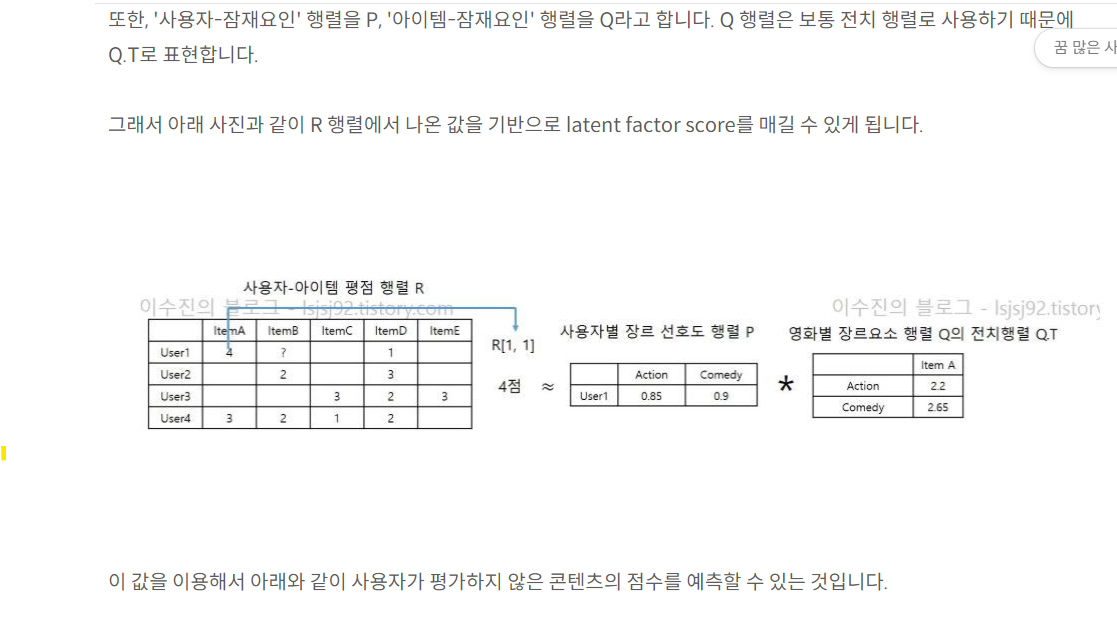

In [234]:
!pip install datasets

from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from datasets import load_dataset

## 데이터로드 및 전처리

도서관데이터

In [235]:
# 필요한 컬럼 # 시설명, 구이름, 장소구분
lib = pd.read_csv('seoul_libs.csv', encoding='utf-8')
lib.head()

# 밸류값이 모두 'lib'인 ['type'] 칼럼 추가
lib['type'] = 'lib'

# 컬럼명 변경
cols= {'도서관 일련번호':'place_id', '도서관명':'place_name', '구명':'gu_name'}
lib = lib.rename(columns=cols)
lib.columns

# # 필요한 컬럼만 추출
lib=lib[['place_name', 'gu_name', 'type']]
lib.head()


,place_name,gu_name,type
0,BIBLIOTECA,강남구,lib
1,LH강남3단지작은도서관,강남구,lib
2,休+밤토리SH작은도서관,강남구,lib
3,강남구립못골도서관,강남구,lib
4,강남데시앙파크작은도서관,강남구,lib


공원데이터

In [236]:
# 필요한 컬럼 # 시설명, 구이름, 장소구분
par = pd.read_csv('seoul_parks.csv', encoding='utf-8')
par.head()
par.columns
# 밸류값이 모두 'par'인 ['type'] 칼럼 추가
par['type'] = 'par'

# 컬럼명 변경
cols= {'공원명':'place_name', '공원주소':'gu_name'}
par = par.rename(columns=cols)
par.columns

# 공원주소 컬럼에서 구 이름만 추출
par['gu_name'] = par['gu_name'].str.split(' ', expand=True)[1]

# 결측치 삭제
par = par.dropna()

# gu_name이 '구'로 끝나지 않으면 삭제
par = par[par['gu_name'].str.endswith('구')]

# # 필요한 컬럼만 추출
par=par[['place_name', 'gu_name', 'type']]
par.head()

,place_name,gu_name,type
0,남산도시자연공원,중구,par
12,여의도근린공원,영등포구,par
16,보라매근린공원,동작구,par
17,어린이대공원,광진구,par
18,천호근린공원,강동구,par


박물관, 미술관 데이터

In [237]:
dataset = load_dataset("hscrown/seoul_museums")
muse = pd.DataFrame(dataset['train'])

muse.columns

# 밸류값이 모두 'muse'인 ['type'] 칼럼 추가
muse['type'] = 'muse'

# 컬럼명 변경
cols= {'시설명':'place_name', '주소':'gu_name'}
muse = muse.rename(columns=cols)

# 주소 컬럼에서 구 이름만 추출
muse['gu_name'] = muse['gu_name'].str.split(' ', expand=True)[1]

# gu_name이 '구'로 끝나지 않으면 삭제
muse = muse[muse['gu_name'].str.endswith('구')]
# # 필요한 컬럼만 추출
muse=muse[['place_name', 'gu_name', 'type']]

muse.tail()

Repo card metadata block was not found. Setting CardData to empty.


,place_name,gu_name,type
170,매헌윤봉길의사기념관,서초구,muse
171,동덕여자대학교 박물관,성북구,muse
172,DDP디자인뮤지엄,중구,muse
173,아모레퍼시픽미술관,용산구,muse
174,롯데뮤지엄,송파구,muse


In [238]:
# 공원데이터와 도서관 데이터 합침
df = pd.concat([lib, par,muse])
df.tail()

# 인덱스 초기화
df = df.reset_index(drop=True)

# 'place_id' 컬럼 만들고 인덱스 밸류로 넣기
df['place_id'] = df.index

df.head()

# df 를 csv 파일로 변환
df.to_csv('places.csv', index=False, encoding='utf-8')

In [239]:
df.tail()

,place_name,gu_name,type,place_id
1658,매헌윤봉길의사기념관,서초구,muse,1658
1659,동덕여자대학교 박물관,성북구,muse,1659
1660,DDP디자인뮤지엄,중구,muse,1660
1661,아모레퍼시픽미술관,용산구,muse,1661
1662,롯데뮤지엄,송파구,muse,1662


# 사용자 평점데이터 만들기

In [240]:
import pandas as pd
import numpy as np

def generate_user_ratings(num_users):
    # df가 이미 정의되어 있다고 가정해. 없으면 먼저 정의해야 돼.
    users = [df.copy() for _ in range(num_users)]

    # 'place_name' 열은 필요 없고, 열 이름을 바꾸자
    for user_id, user_df in enumerate(users):
        user_df.drop(columns='place_name', inplace=True)
        user_df.columns = ['user_id', 'rating','place_id']
        user_df['user_id'] = user_id

    # 사용자 데이터프레임을 합치자
    user_rating = pd.concat(users)

    # 'rating' 열의 NaN 값을 0으로 채워
    user_rating['rating'] = user_rating['rating'].fillna(0)

    # 평점을 평균이 3.5이고 표준 편차가 1.5인 분포로 나오게해서 정규분포와 비슷하면서 0값이 나오게함.
    ratings_mean = 3.5
    ratings_std = 1.5
    raw_ratings = np.random.normal(ratings_mean, ratings_std, size=len(user_rating))

    # 평점을 가장 가까운 0.5로 반올림해
    rounded_ratings = np.round(raw_ratings * 2) / 2

    # 평점을 0과 5 사이로 맞춰
    rounded_ratings = np.clip(rounded_ratings, 0, 5)

    user_rating['rating'] = rounded_ratings

    return user_rating

# 사용자 수를 바꿔서 테스트해봐
num_users = 1000
user_rating = generate_user_ratings(num_users)
user_rating.tail()


,user_id,rating,place_id
1658,999,3.0,1658
1659,999,3.0,1659
1660,999,4.0,1660
1661,999,2.5,1661
1662,999,1.5,1662


In [241]:
user_rating.to_csv(f'user_rating_{num_users}.csv', index=False, encoding='utf-8')

아이템-특성 데이터 만들기

In [242]:
# place_id, type, place_name만 추출
item_feature = df[['place_id', 'type', 'place_name']]
item_feature.head()

,place_id,type,place_name
0,0,lib,BIBLIOTECA
1,1,lib,LH강남3단지작은도서관
2,2,lib,休+밤토리SH작은도서관
3,3,lib,강남구립못골도서관
4,4,lib,강남데시앙파크작은도서관


# 추천시스템구현

데이터확인

In [243]:
# 사용자-장소 평점기반데이터
user_rating.shape  # (4989, 3)

(1663000, 3)

In [244]:
# 장소 정보 데이터
item_feature = item_feature[['place_id','place_name']]
item_feature

,place_id,place_name
0,0,BIBLIOTECA
1,1,LH강남3단지작은도서관
2,2,休+밤토리SH작은도서관
3,3,강남구립못골도서관
4,4,강남데시앙파크작은도서관
...,...,...
1658,1658,매헌윤봉길의사기념관
1659,1659,동덕여자대학교 박물관
1660,1660,DDP디자인뮤지엄
1661,1661,아모레퍼시픽미술관


In [245]:
user_place_data = pd.merge(user_rating, item_feature, on='place_id')
user_place_data.head()

,user_id,rating,place_id,place_name
0,0,3.5,0,BIBLIOTECA
1,1,1.5,0,BIBLIOTECA
2,2,4.0,0,BIBLIOTECA
3,3,1.5,0,BIBLIOTECA
4,4,2.5,0,BIBLIOTECA


In [246]:
user_place_data.shape # (4989, 4)

(1663000, 4)

In [247]:
# 사용자-평점데이터로 변경
df_user_place_ratings = user_place_data.pivot_table(index='user_id', columns='place_id', values='rating')
df_user_place_ratings.head()

place_id,0,1,2,3,4,5,6,7,8,9,...,1653,1654,1655,1656,1657,1658,1659,1660,1661,1662
user_id,,,,,,,,,,,,,,,,,,,,,
0,3.5,5.0,2.5,2.0,4.0,4.5,3.5,4.0,0.5,4.0,...,3.5,4.0,5.0,4.0,2.5,3.5,0.5,5.0,0.5,5.0
1,1.5,3.5,5.0,3.5,3.0,3.5,4.0,1.0,5.0,2.5,...,5.0,4.5,1.5,4.0,4.0,5.0,2.5,3.0,2.0,4.5
2,4.0,4.5,4.0,2.0,2.0,5.0,5.0,4.0,4.0,1.5,...,5.0,2.5,2.5,1.0,1.5,3.0,4.0,1.5,0.0,2.0
3,1.5,4.5,5.0,3.0,4.0,3.0,3.5,3.0,5.0,0.0,...,4.0,4.0,5.0,0.5,5.0,1.5,2.0,4.5,3.0,2.0
4,2.5,3.5,1.5,5.0,0.5,5.0,2.5,5.0,5.0,0.5,...,2.0,3.0,4.5,5.0,5.0,4.0,3.0,3.5,4.5,3.0


여기까지는 앞서 했던 것과 똑같습니다. 사용자-영화 pivot table을 만드는 것이죠.

이제 아래와 같이 데이터를 조금 변경해서 진행하겠습니다.

pivot table을 matrix로 변환
np.mean(axis = 1)을 통해 각 사용자들이 매기는 평점 평균을 구함
1에서 구한 값과 2에서 구한 값을 빼서 사용자-평균 데이터 값을 변경

In [248]:
print(df_user_place_ratings.columns.dtype)

int64


In [249]:
print(df_user_place_ratings.columns.dtype)

int64


In [250]:
df_user_place_ratings.columns = df_user_place_ratings.columns.astype(str)

In [251]:
# matrix는 pivot_table 값을 numpy matrix로 만든 것
df_user_place_ratings.columns = df_user_place_ratings.columns.str.strip() # 화이트스페이스 지우기
matrix = df_user_place_ratings.values #as_matrix function은 depricated.
matrix
# # user_ratings_mean은 사용자의 평균 평점
user_ratings_mean = np.mean(matrix, axis = 1)

# # R_user_mean : 사용자-영화에 대해 사용자 평균 평점을 뺀 것.
matrix_user_mean = matrix - user_ratings_mean.reshape(-1, 1)

In [252]:
matrix

array([[3.5, 5. , 2.5, ..., 5. , 0.5, 5. ],
       [1.5, 3.5, 5. , ..., 3. , 2. , 4.5],
       [4. , 4.5, 4. , ..., 1.5, 0. , 2. ],
       ...,
       [4.5, 2. , 4. , ..., 1.5, 0.5, 5. ],
       [5. , 4.5, 2.5, ..., 4.5, 4. , 4. ],
       [3.5, 3.5, 5. , ..., 4. , 2.5, 1.5]])

In [253]:
matrix.shape # (3, 1663)

(1000, 1663)

In [254]:
user_ratings_mean.shape

(1000,)

In [255]:
matrix_user_mean.shape

(1000, 1663)

In [256]:
pd.DataFrame(matrix_user_mean, columns = df_user_place_ratings.columns).head()

place_id,0,1,2,3,4,5,6,7,8,9,...,1653,1654,1655,1656,1657,1658,1659,1660,1661,1662
0,0.106133,1.606133,-0.893867,-1.393867,0.606133,1.106133,0.106133,0.606133,-2.893867,0.606133,...,0.106133,0.606133,1.606133,0.606133,-0.893867,0.106133,-2.893867,1.606133,-2.893867,1.606133
1,-1.952195,0.047805,1.547805,0.047805,-0.452195,0.047805,0.547805,-2.452195,1.547805,-0.952195,...,1.547805,1.047805,-1.952195,0.547805,0.547805,1.547805,-0.952195,-0.452195,-1.452195,1.047805
2,0.597414,1.097414,0.597414,-1.402586,-1.402586,1.597414,1.597414,0.597414,0.597414,-1.902586,...,1.597414,-0.902586,-0.902586,-2.402586,-1.902586,-0.402586,0.597414,-1.902586,-3.402586,-1.402586
3,-1.908298,1.091702,1.591702,-0.408298,0.591702,-0.408298,0.091702,-0.408298,1.591702,-3.408298,...,0.591702,0.591702,1.591702,-2.908298,1.591702,-1.908298,-1.408298,1.091702,-0.408298,-1.408298
4,-0.917017,0.082983,-1.917017,1.582983,-2.917017,1.582983,-0.917017,1.582983,1.582983,-2.917017,...,-1.417017,-0.417017,1.082983,1.582983,1.582983,0.582983,-0.417017,0.082983,1.082983,-0.417017


여기까지 진행하면 초기에 만들었던 user-place pivot table 값이 matrix_user_mean 로 변경된것임.

사용자 3명이 1663개의 영화에 대해 평점을 매긴 값이 존재
사용자 3명의 각각 평균 평점을 구해서
사용자 3명의 1663개의 장소에 대해 평점을 조금 변경 -> 1에서 구한 값 - 2에서 구한 값
이제 SVD를 이용해 Matrix Factorization을 진행

4번에서는 scikit learn을 이용해 TruncatedSVD를 이용했는데요. 이번에는 scipy를 이용해 Truncated SVD를 구해봅니다.

이 둘의 차이점은 scikit learn에서 제공해주는 TruncatedSVD는 U, Sigma, Vt 반환 값을 제공하지 않습니다.
하지만, Scipy를 이용하면 이 반환값들을 제공받을 수 있죠.

Scipy에서 제공해주는 Truncate SVD는 scipy.sparse.linalg.svds를 이용하면 됩니다. 저는 이것을 이용했습니다.

이렇게 사용하면 반환값이 U 행렬, Sigma 행렬, V 전치 행렬(Vt)가 나오게 됩니다.

In [257]:

# scipy에서 제공해주는 svd.
# U 행렬, sigma 행렬, V 전치 행렬을 반환.

U, sigma, Vt = svds(matrix_user_mean, k = 1)

In [258]:
print(U.shape)
print(sigma.shape)
print(Vt.shape)
# 현재 이 Sigma 행렬은 0이 아닌 값만 1차원 행렬로 표현된 상태입니다.
# 즉, 0이 포함된 대칭행렬로 변환할 때는 numpy의 diag를 이용해야 합니다.

(1000, 1)
(1,)
(1, 1663)


In [259]:

sigma = np.diag(sigma)

In [260]:
sigma.shape

(1, 1)

In [263]:

sigma[0]

array([92.91503091])

이렇게 대칭 행렬로 변환이 되었습니다.

현재 까지 상황을 정리하면 아래와 같습니다.

원본 user-movie 평점 행렬이 있었음
이를 user의 평균 점수를 빼서 matrix_user_mean 이라는 행렬로 만듬
2번의 값을 SVD를 적용해 U, Sigma, Vt 행렬을 구했음
Sigma 행렬은 현재 0이 포함이 되지 않은 값으로만 구성되어 있음. 이를 대칭행렬로 변환
자! 이제 여기서 matrix_user_mean을 SVD를 적용해 분해를 한 상태입니다.
이제, 다시 원본 행렬로 복구시켜야겠죠?

원본 행렬로 복구시키는 방법은 아래와 같습니다.

U, Sigma, Vt의 내적을 수행
즉, np.dot(np.dot(U, sigma), Vt)를 수행하면 됩니다.

그리고 아까 사용자 평균을 빼주었으니 여기서는 더해줍니다.

In [264]:
# U, Sigma, Vt의 내적을 수행하면, 다시 원본 행렬로 복원이 된다.
# 거기에 + 사용자 평균 rating을 적용한다.
svd_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

In [265]:
df_svd_preds = pd.DataFrame(svd_user_predicted_ratings, columns = df_user_place_ratings.columns)
df_svd_preds.head()

place_id,0,1,2,3,4,5,6,7,8,9,...,1653,1654,1655,1656,1657,1658,1659,1660,1661,1662
0,3.393282,3.392628,3.390144,3.401461,3.391077,3.401570,3.393680,3.388801,3.388402,3.378471,...,3.398251,3.410583,3.391560,3.379514,3.396041,3.393768,3.390348,3.413915,3.389908,3.410525
1,3.455575,3.459357,3.473724,3.408268,3.468329,3.407636,3.453272,3.481495,3.483801,3.541242,...,3.426837,3.355506,3.465536,3.535209,3.439620,3.452762,3.472548,3.336237,3.475093,3.355841
2,3.400006,3.397121,3.386158,3.436105,3.390274,3.436587,3.401764,3.380227,3.378468,3.334636,...,3.421936,3.476366,3.392406,3.339240,3.412181,3.402153,3.387054,3.491070,3.385113,3.476111
3,3.407859,3.407367,3.405500,3.414009,3.406201,3.414091,3.408158,3.404489,3.404190,3.396722,...,3.411595,3.420868,3.406564,3.397506,3.409933,3.408225,3.405652,3.423373,3.405322,3.420824
4,3.416979,3.416937,3.416775,3.417512,3.416836,3.417519,3.417005,3.416688,3.416662,3.416015,...,3.417303,3.418106,3.416867,3.416083,3.417159,3.417011,3.416788,3.418323,3.416760,3.418102


In [266]:
df_svd_preds.shape

(1000, 1663)


자! 이제 함수를 하나 만듭니다. 이 함수의 기능은 아래와 같습니다.

인자로 사용자 아이디, 영화 정보 테이블, 평점 테이블 등을 받음
사용자 아이디에 SVD로 나온 결과의 영화 평점이 가장 높은 데이터 순으로 정렬
사용자가 본 데이터를 제외
사용자가 안 본 영화에서 평점이 높은 것을 추천

In [267]:
# def recommend_places(df_svd_preds, user_id, ori_places_df, ori_ratings_df, num_recommendations=5):

df_svd_preds = df_svd_preds
user_id = 0
ori_places_df = item_feature
ori_ratings_df = user_rating
num_recommendations = 5

# # 사용자의 예측 평점이 높은 순으로 정렬된 데이터
user_row_number = user_id
sorted_user_predictions = df_svd_preds.iloc[user_row_number].sort_values(ascending=False)

sorted_user_predictions = pd.DataFrame(sorted_user_predictions.reset_index())
sorted_user_predictions.columns = ['place_id', 'predict_rating']

sorted_user_predictions['place_id'] = sorted_user_predictions['place_id'].astype('int64')

# 원본 평점 데이터에서 user id에 해당하는 데이터를 추출
user_data = ori_ratings_df[ori_ratings_df['user_id'] == user_id]
# 원본 평점 데이터에서 user id에 해당하는 데이터를 추출
user_data = ori_ratings_df[ori_ratings_df['user_id'] == user_id]

# user_data에서 평점이 0인데이터는 아직 안가본것이므로 삭제
user_data = user_data[user_data['rating']!=0.0]

# (가본장소)추출된 데이터와 원본 장소 데이터를 합침
user_history = user_data.merge(ori_places_df, on='place_id').sort_values(['rating'], ascending=False)

# 사용자가 평가하지 않은 장소를 추천 대상으로 설정
recommendations = ori_places_df[~ori_places_df['place_id'].isin(user_history['place_id'])]

# 'place_id'를 int64로 변경
recommendations['place_id'] = recommendations['place_id'].astype('int64')

# sorted_user_predictions과 recommendations를 합침
recommendations = pd.merge(sorted_user_predictions,recommendations, on='place_id')

# 정렬해서 리턴
recommendations = recommendations.sort_values(['predict_rating'], ascending=False).head(num_recommendations)




In [268]:
sorted_user_predictions

,place_id,predict_rating
0,347,3.443173
1,646,3.441388
2,784,3.438772
3,989,3.437903
4,991,3.437690
...,...,...
1658,1271,3.352283
1659,863,3.349729
1660,1609,3.346706
1661,1110,3.346172


In [269]:
user_history

,user_id,rating,place_id,place_name
1635,0,5.0,1662,롯데뮤지엄
629,0,5.0,636,한국과학기술원고등과학원도서실
633,0,5.0,640,휘경2동꿈빛누리작은도서관
247,0,5.0,249,초록동작은도서관
635,0,5.0,642,휘경행복도서관
...,...,...,...,...
1172,0,0.5,1188,한국노동조합총연맹도서관
482,0,0.5,487,글빛작은도서관
476,0,0.5,481,해오름작은도서관
370,0,0.5,373,고척열린도서관


In [270]:
recommendations

,place_id,predict_rating,place_name
0,634,3.416023,청솔우성아파트 작은도서관
1,454,3.412650,금천구립금나래도서관
2,1374,3.410275,한식도서관
3,1257,3.409660,모퉁이작은도서관
4,890,3.402446,성동구립용답도서관


# 성능평가

In [277]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

# 데이터 로드와 전처리
# df = pd.read_csv('places.csv', index_col=False, encoding='utf-8')
# user_rating = pd.read_csv('user_rating_1000.csv', index_col=False, encoding='utf-8')
df_user_place_ratings = pd.pivot_table(data=user_rating, index='user_id', columns='place_id', values='rating', fill_value=0)

# 전체 데이터셋에서 평균을 구하고, 평균을 빼서 중앙화
matrix = df_user_place_ratings.values
user_ratings_mean = np.mean(matrix, axis=1)
matrix_user_mean = matrix - user_ratings_mean.reshape(-1, 1)

# 훈련 데이터와 테스트 데이터 분리
train_data, test_data = train_test_split(matrix_user_mean, test_size=0.2, random_state=42)
train_user_ratings_mean = np.mean(train_data, axis=1)

# k 값의 범위 설정
ks = [1,2,3,4,5,6,7,8,9,10]
metrics = []

# k 값에 따른 SVD 수행 및 평가 지표 계산
for k in ks:
    U, sigma, Vt = svds(train_data, k=k)
    sigma = np.diag(sigma)
    all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean[:train_data.shape[0]].reshape(-1, 1)

    # 테스트 데이터의 예측
    predicted_ratings = all_user_predicted_ratings[test_data.nonzero()]
    actual_ratings = test_data[test_data.nonzero()]

    # 평가 지표 계산
    mse = mean_squared_error(actual_ratings, predicted_ratings)
    mae = mean_absolute_error(actual_ratings, predicted_ratings)
    correlation = np.corrcoef(actual_ratings, predicted_ratings)[0, 1]
    threshold = 3.5
    accuracy = np.mean((actual_ratings >= threshold) == (predicted_ratings >= threshold))
    precision = np.sum((actual_ratings >= threshold) & (predicted_ratings >= threshold)) / np.sum(predicted_ratings >= threshold)
    recall = np.sum((actual_ratings >= threshold) & (predicted_ratings >= threshold)) / np.sum(actual_ratings >= threshold)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # 저장
    metrics.append((k, mse, mae, correlation, accuracy, precision, recall, f1_score))

# 결과 출력
for metric in metrics:
    k, mse, mae, correlation, accuracy, precision, recall, f1_score = metric
    print(f'k={k}: MSE={mse:.4f}, MAE={mae:.4f}, Correlation={correlation:.4f}, Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={f1_score:.4f}')


k=1: MSE=13.1289, MAE=3.3821, Correlation=0.0026, Accuracy=0.9487, Precision=0.0000, Recall=nan, F1 Score=nan
k=2: MSE=13.1350, MAE=3.3821, Correlation=0.0006, Accuracy=0.8931, Precision=0.0000, Recall=nan, F1 Score=nan
k=3: MSE=13.1406, MAE=3.3821, Correlation=0.0018, Accuracy=0.8466, Precision=0.0000, Recall=nan, F1 Score=nan
k=4: MSE=13.1461, MAE=3.3821, Correlation=0.0019, Accuracy=0.8077, Precision=0.0000, Recall=nan, F1 Score=nan
k=5: MSE=13.1525, MAE=3.3821, Correlation=0.0011, Accuracy=0.7792, Precision=0.0000, Recall=nan, F1 Score=nan
k=6: MSE=13.1588, MAE=3.3821, Correlation=0.0005, Accuracy=0.7558, Precision=0.0000, Recall=nan, F1 Score=nan
k=7: MSE=13.1642, MAE=3.3821, Correlation=-0.0003, Accuracy=0.7407, Precision=0.0000, Recall=nan, F1 Score=nan
k=8: MSE=13.1694, MAE=3.3821, Correlation=0.0007, Accuracy=0.7248, Precision=0.0000, Recall=nan, F1 Score=nan
k=9: MSE=13.1746, MAE=3.3821, Correlation=0.0005, Accuracy=0.7118, Precision=0.0000, Recall=nan, F1 Score=nan
k=10: MSE

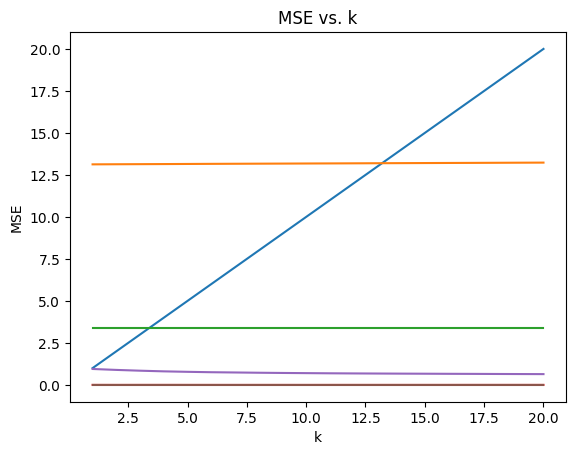

In [276]:
# k값에 따른 시각화
plt.plot(ks, metrics)
plt.xlabel('k')
plt.ylabel('MSE')
plt.title('MSE vs. k')
plt.show()

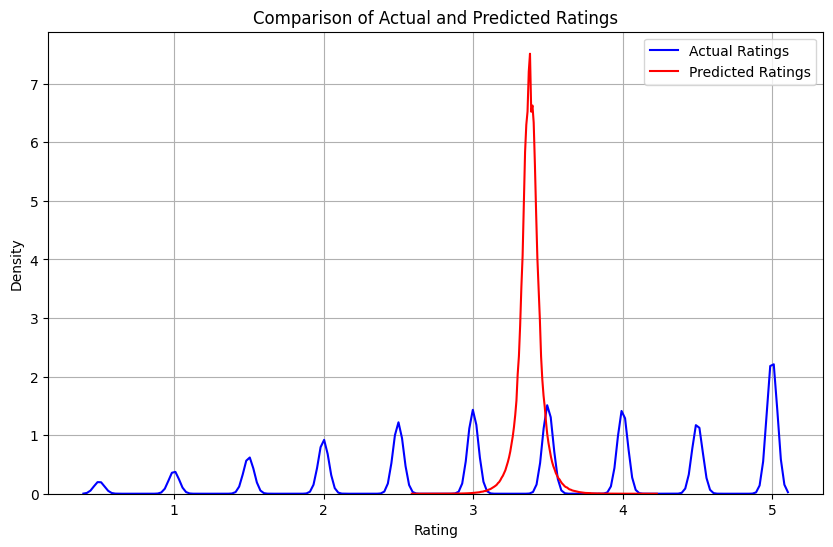

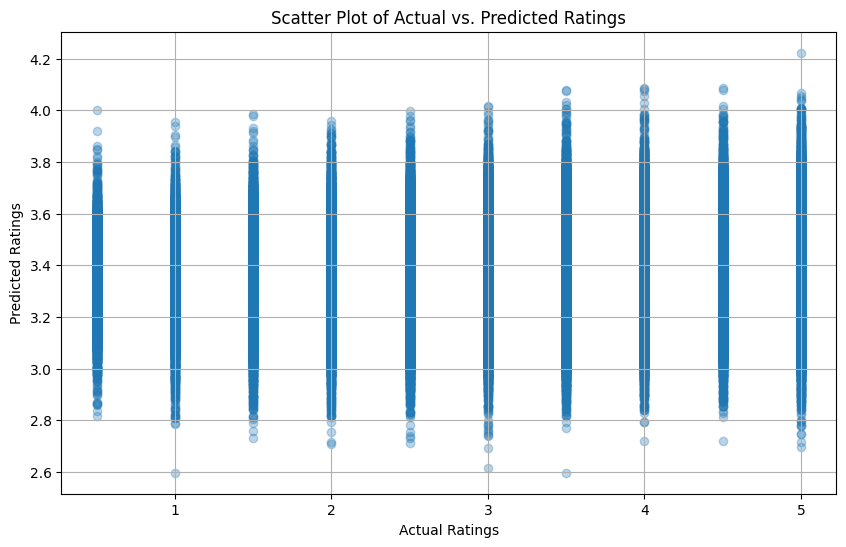

In [278]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 데이터에서 평점이 0인 데이터 제외
non_zero_indices = df_user_place_ratings.values.flatten() != 0
actual_ratings = df_user_place_ratings.values.flatten()[non_zero_indices]
predicted_ratings = df_svd_preds.values.flatten()[non_zero_indices]

# 실제 평점과 예측 평점의 분포 비교
plt.figure(figsize=(10, 6))
sns.kdeplot(actual_ratings, bw_adjust=0.5, label='Actual Ratings', color='blue')
sns.kdeplot(predicted_ratings, bw_adjust=0.5, label='Predicted Ratings', color='red')
plt.title('Comparison of Actual and Predicted Ratings')
plt.xlabel('Rating')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

# 실제 평점과 예측 평점의 산점도
plt.figure(figsize=(10, 6))
plt.scatter(actual_ratings, predicted_ratings, alpha=0.3)
plt.title('Scatter Plot of Actual vs. Predicted Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.grid(True)
plt.show()


결과에서 볼 수 있듯이, 각 k 값에 대한 MSE와 MAE는 비슷한 수준을 유지하고 있으며, 상관계수는 매우 낮은 값을 보여주고 있습니다. 정확도는 비교적 높지만, Precision이 0이고 Recall과 F1 Score가 NaN으로 나타나고 있습니다. 이는 몇 가지 중요한 문제를 지적하고 있습니다:

Precision과 Recall의 NaN 문제:


Precision이 0이라는 것은 모델이 실제로 긍정적인 평가를 예측하는 경우가 없었다는 것을 의미합니다. 즉, 예측된 평점이 임계값(3.5) 이상인 경우가 전혀 없었습니다.
Recall이 NaN으로 나타나는 것은 실제 데이터 중 긍정적인 예 (실제 평점이 임계값 이상인 경우)가 없기 때문일 수 있습니다. 이는 테스트 데이터셋에서 실제로 긍정적인 평가가 존재하지 않는다는 것을 의미합니다.

MSE와 MAE:


MSE와 MAE가 상대적으로 높게 유지되고 있습니다. 이는 모델의 예측이 실제 평점과 상당한 차이를 보인다는 것을 의미합니다. 평균적으로 약 3.38의 오차가 발생하고 있어, 추천 시스템의 예측 성능이 좋지 않음을 나타냅니다.

상관계수:


상관계수가 매우 낮습니다 (0.0026에서 -0.0003 사이). 이는 예측된 평점과 실제 평점 간에 거의 상관관계가 없다는 것을 나타냅니다.

정확도:


정확도가 높게 나오는 것은 대부분의 예측 평점과 실제 평점이 임계값 이하로 일치하기 때문일 수 있습니다. 그러나 이것은 모델이 단순히 모든 항목을 부정적으로 예측하는 경향이 있음을 나타낼 수 있으므로, 특히 Precision과 Recall이 0 혹은 NaN으로 나타날 때는 정확도만으로 모델의 성능을 평가하기에는 부적합합니다.